## 1. Set up

In [ ]:
# Install libraries
!pip install pandas numpy matplotlib xgboost seaborn --quiet


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    classification_report
)

# Visualization preference
sns.set(style="whitegrid")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/diabetic_data.csv")


## 2. General review

In [ ]:
# First few rows
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


=== Target Distribution (Counts) ===
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

=== Target Distribution (%) ===
readmitted
NO     53.91
>30    34.93
<30    11.16
Name: proportion, dtype: float64


/tmp/ipython-input-3496668543.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


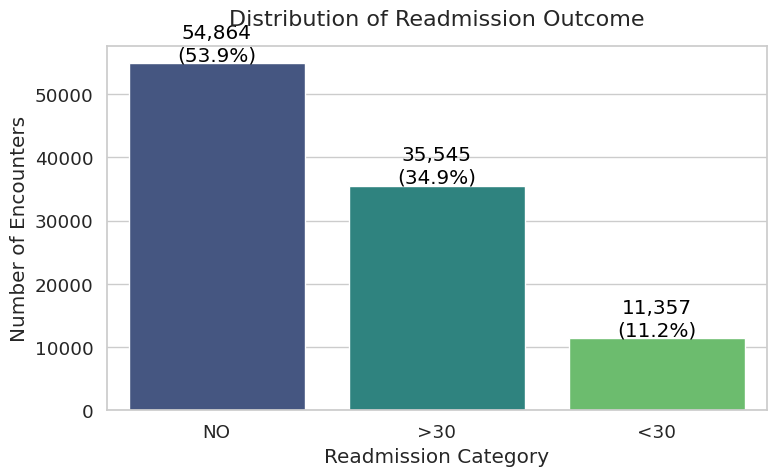

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Get value counts ---
target_counts = df["readmitted"].value_counts()
target_percent = df["readmitted"].value_counts(normalize=True) * 100

print("=== Target Distribution (Counts) ===")
print(target_counts)
print("\n=== Target Distribution (%) ===")
print(target_percent.round(2))

# --- 2. Plot Settings ---
sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8,5))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")

# Add labels on bars
for i, v in enumerate(target_counts.values):
    ax.text(i, v + 500, f"{v:,}\n({target_percent.iloc[i]:.1f}%)",
            color='black', ha='center', fontweight='1')

plt.title("Distribution of Readmission Outcome", fontsize=16, pad=15)
plt.xlabel("Readmission Category")
plt.ylabel("Number of Encounters")
plt.tight_layout()
plt.show()


=== Target Distribution (Counts) ===
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

=== Target Distribution (%) ===
readmitted
NO     53.91
>30    34.93
<30    11.16
Name: proportion, dtype: float64


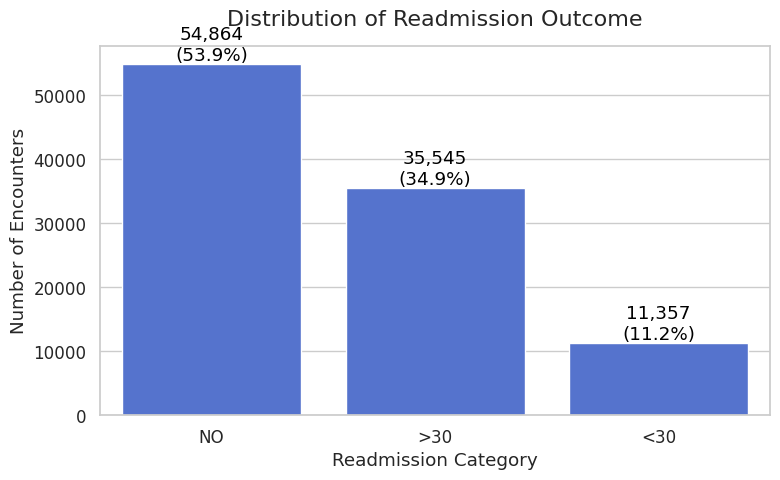

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Get value counts ---
target_counts = df["readmitted"].value_counts()
target_percent = df["readmitted"].value_counts(normalize=True) * 100

print("=== Target Distribution (Counts) ===")
print(target_counts)
print("\n=== Target Distribution (%) ===")
print(target_percent.round(2))

# --- 2. Plot Settings ---
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=target_counts.index,
    y=target_counts.values,
    color="royalblue"  # all bars blue
)

# Add text labels on bars (regular font)
for i, v in enumerate(target_counts.values):
    ax.text(
        i,
        v + 500,
        f"{v:,}\n({target_percent.iloc[i]:.1f}%)",
        color='black',
        ha='center'
    )

plt.title("Distribution of Readmission Outcome", fontsize=16, pad=15)
plt.xlabel("Readmission Category")
plt.ylabel("Number of Encounters")
plt.tight_layout()
plt.show()


In [ ]:
# Dataset shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 101766, Columns: 50


In [ ]:
# Column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [ ]:
# Data types and non-null values
df.dtypes

,0
encounter_id,int64
patient_nbr,int64
race,object
gender,object
age,object
weight,object
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
time_in_hospital,int64


/tmp/ipython-input-3648034662.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dtypes.values, y=dtypes.index.astype(str), palette="pastel")


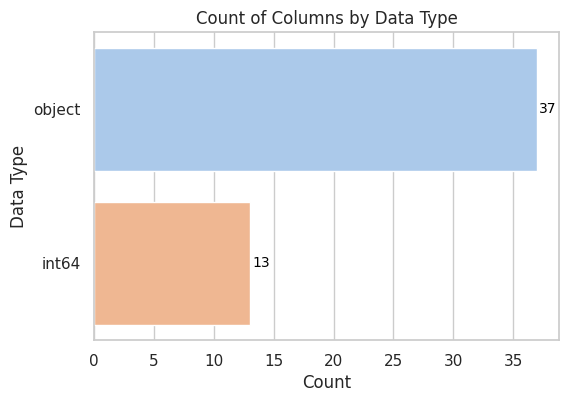

In [ ]:
dtypes = df.dtypes.value_counts()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=dtypes.values, y=dtypes.index.astype(str), palette="pastel")
plt.title("Count of Columns by Data Type")
plt.xlabel("Count")
plt.ylabel("Data Type")

# Add value labels
for i, v in enumerate(dtypes.values):
    ax.text(v + 0.2, i, str(int(v)), color='black', va='center', fontsize=10)

plt.show()



In [ ]:
# Summary statistics for numerical columns
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


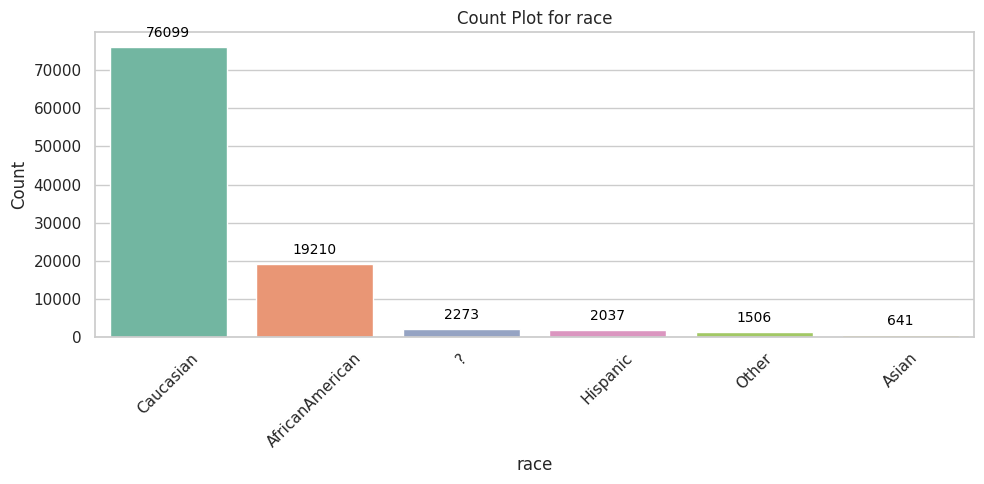

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


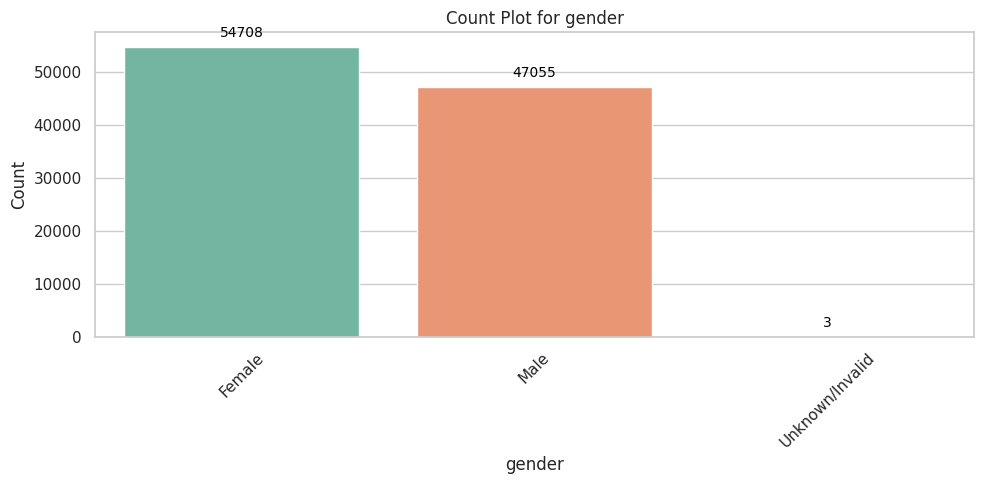

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


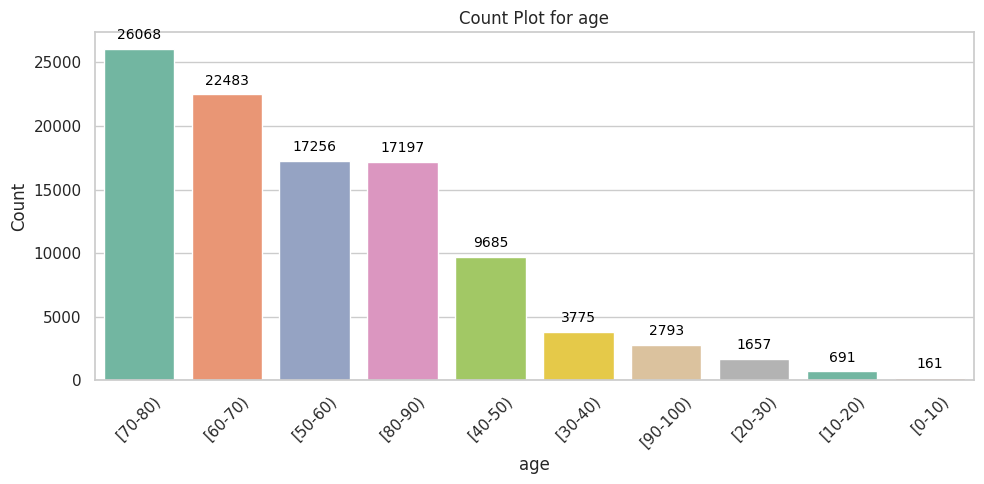

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


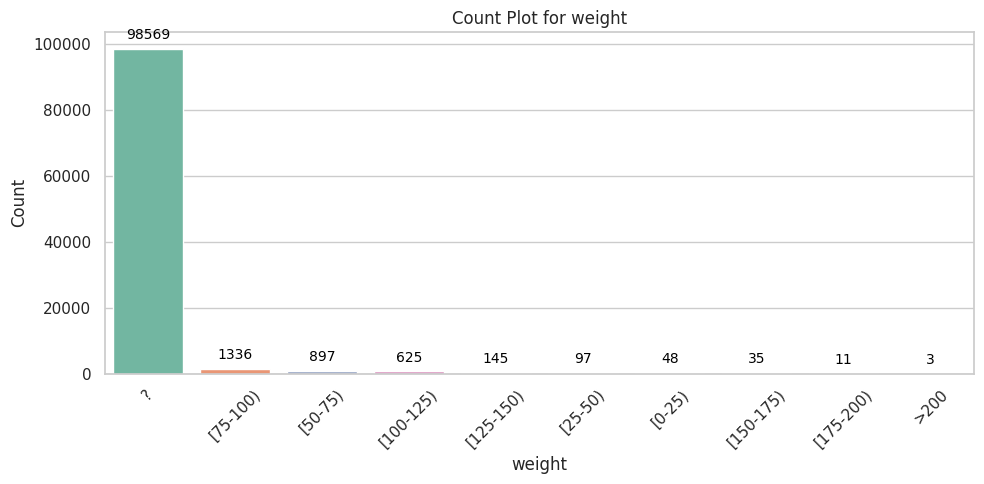

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


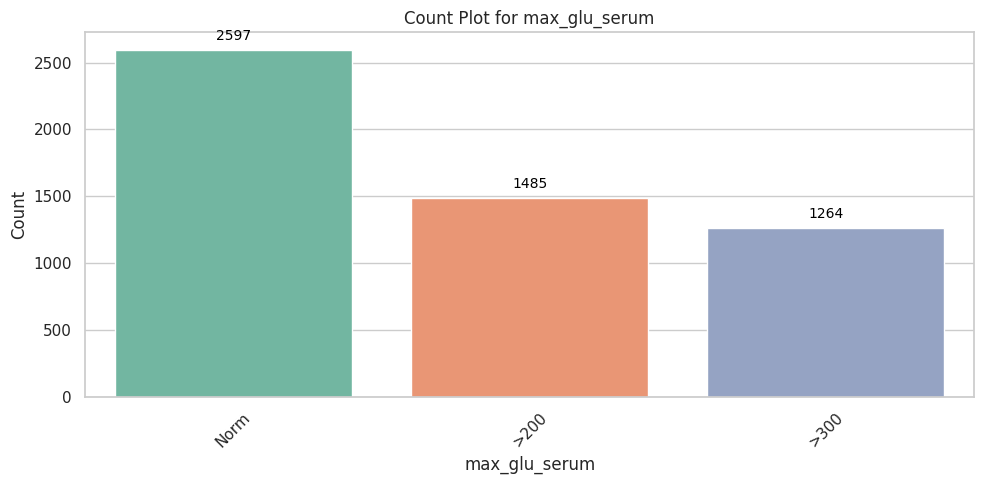

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


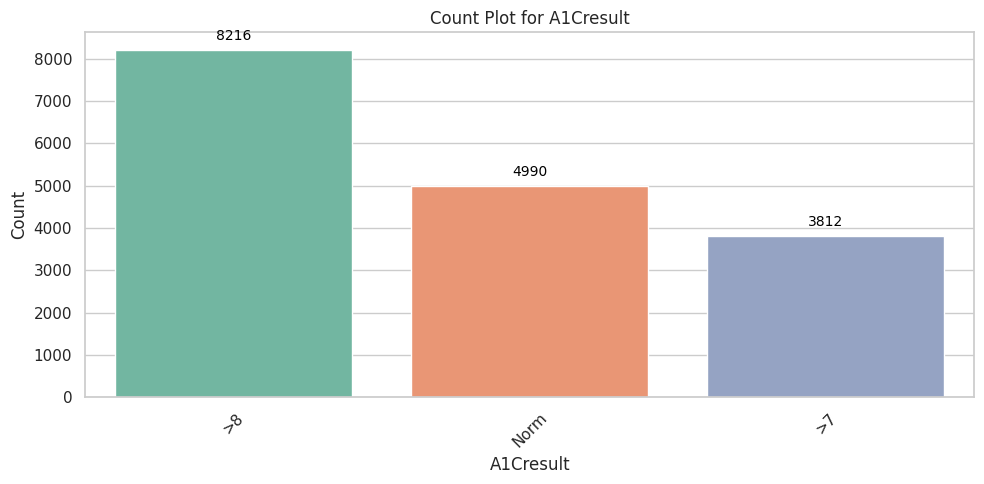

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


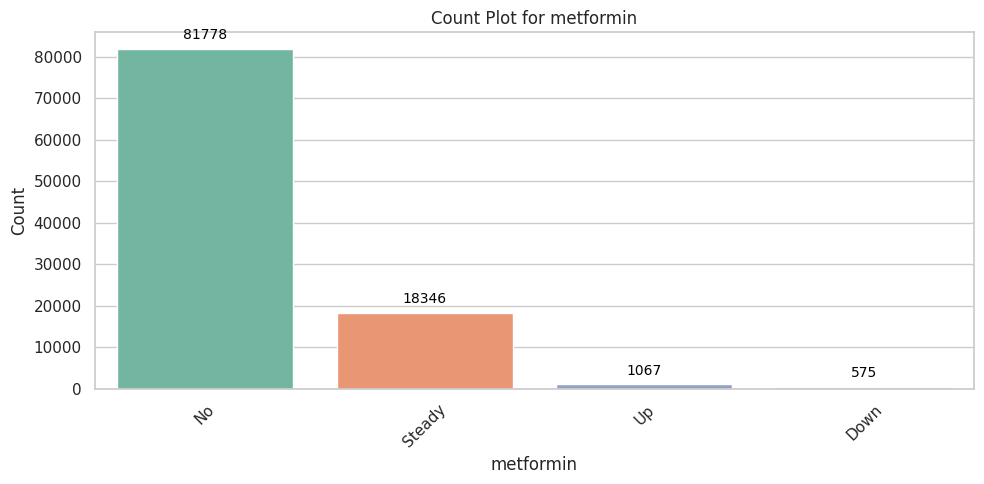

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


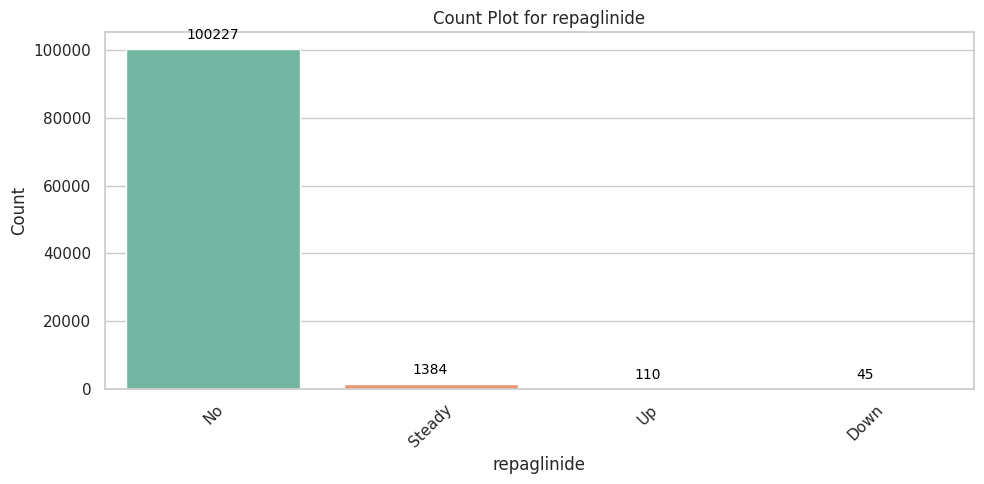

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


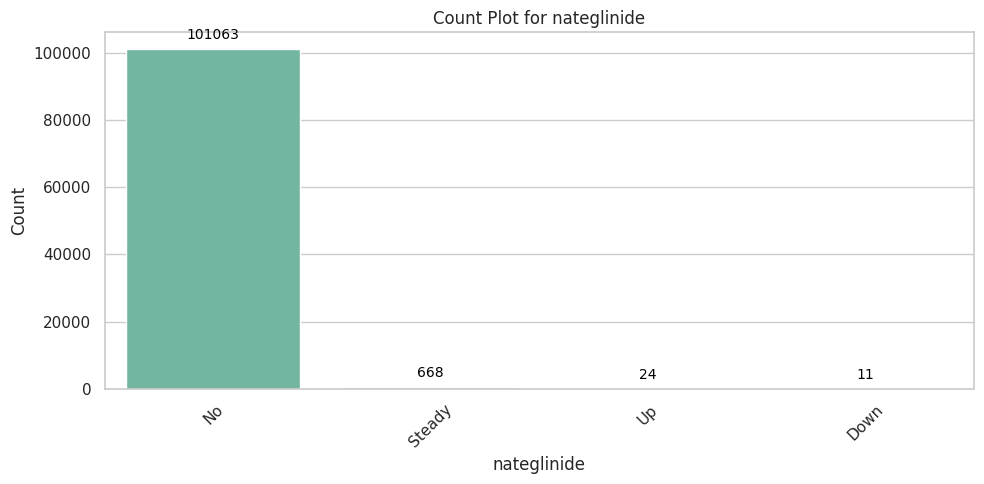

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


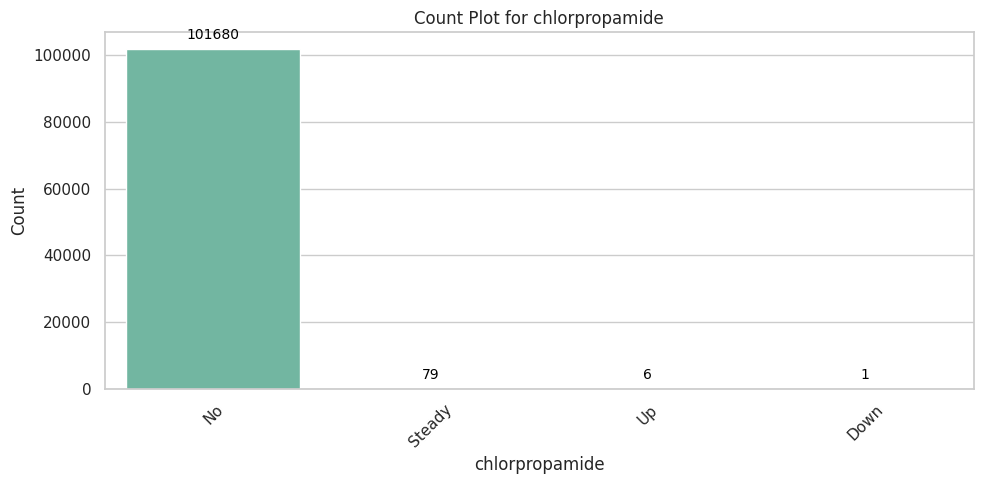

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


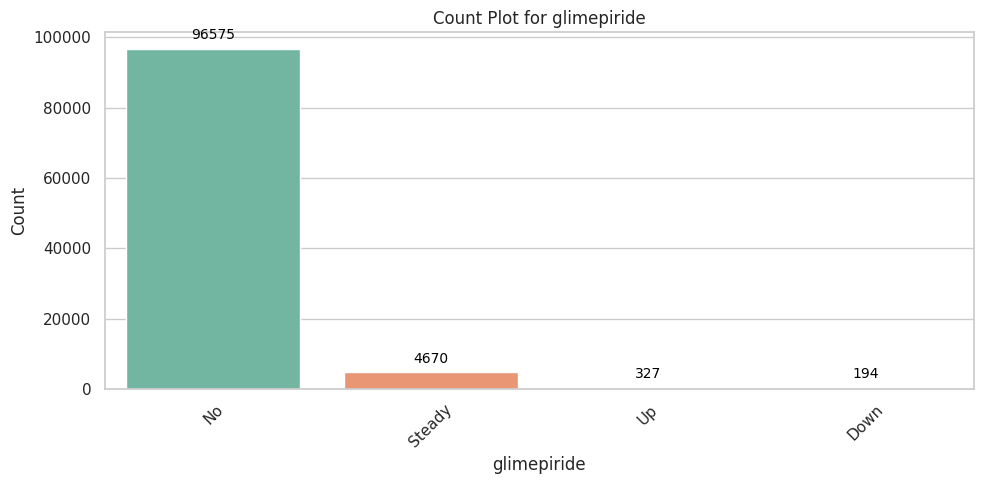

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


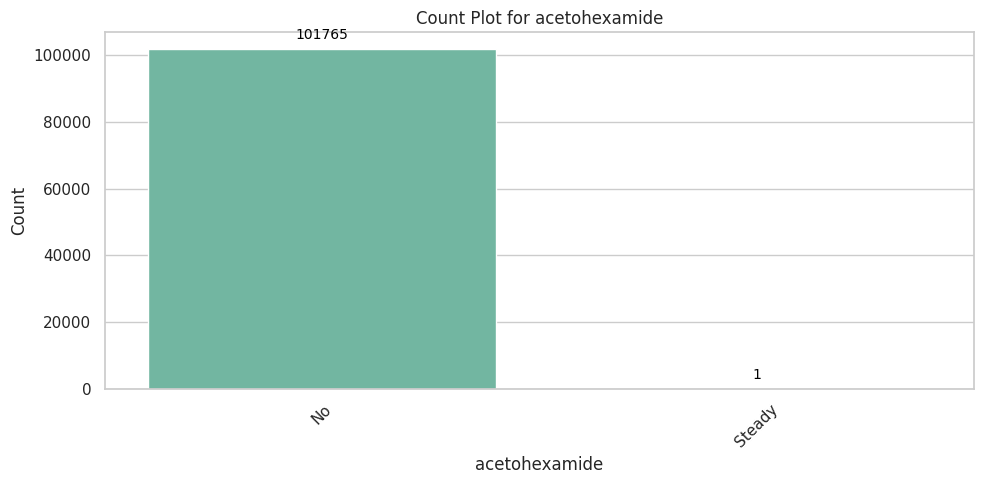

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


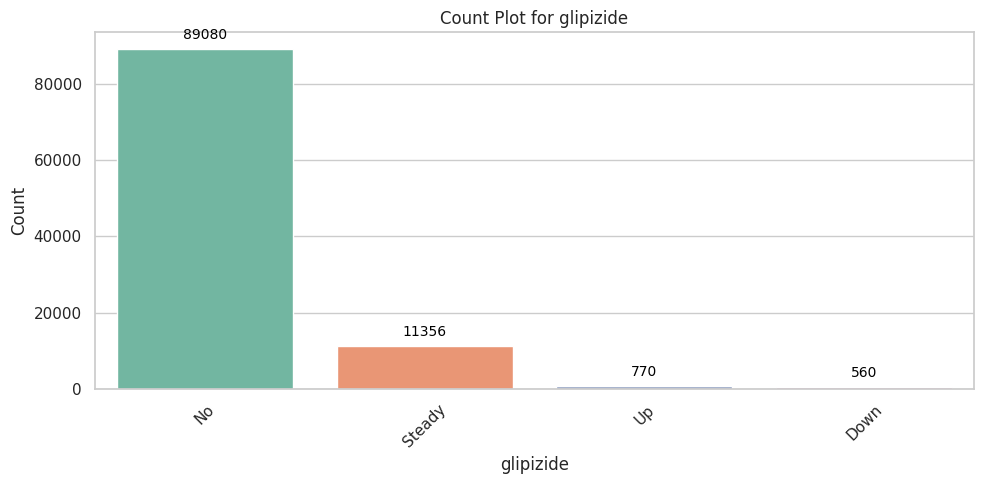

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


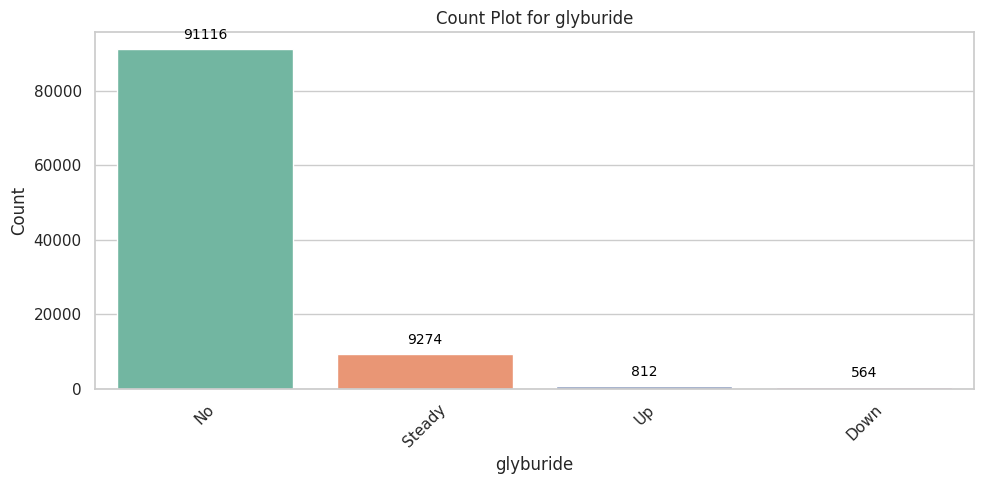

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


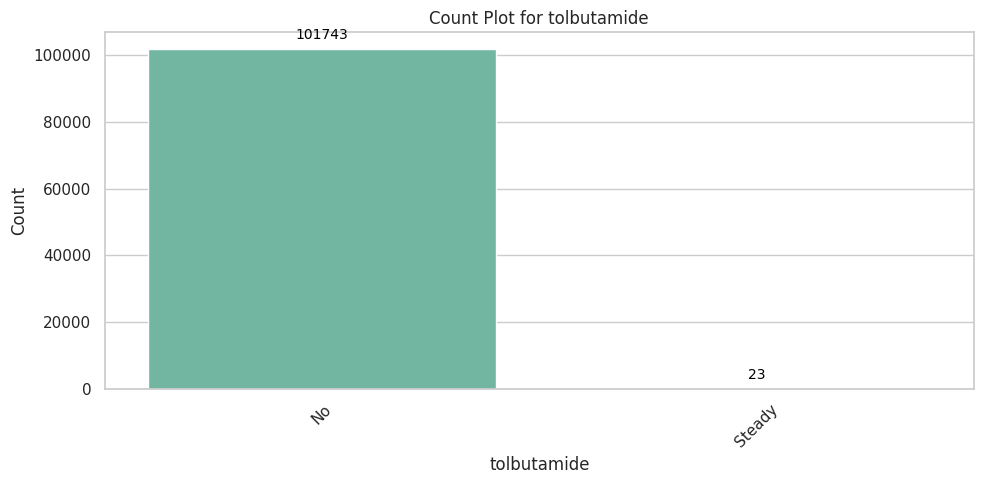

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


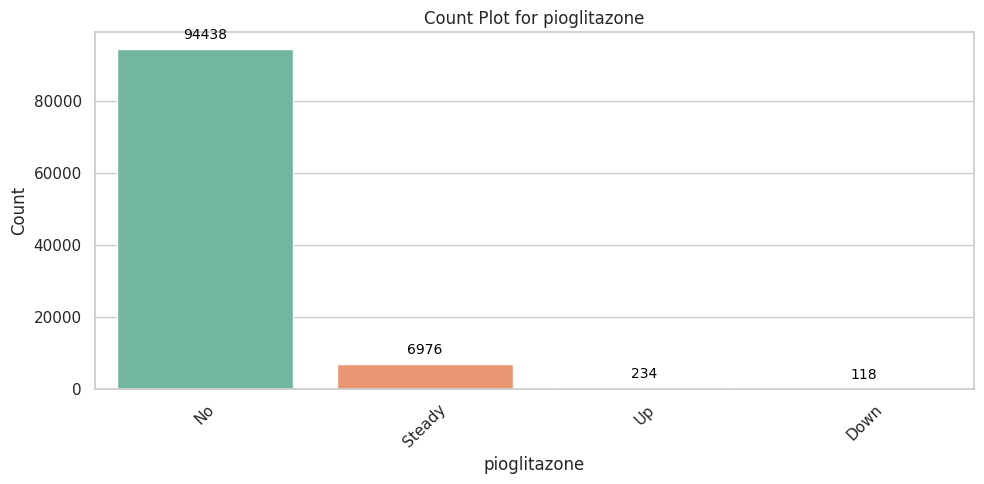

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


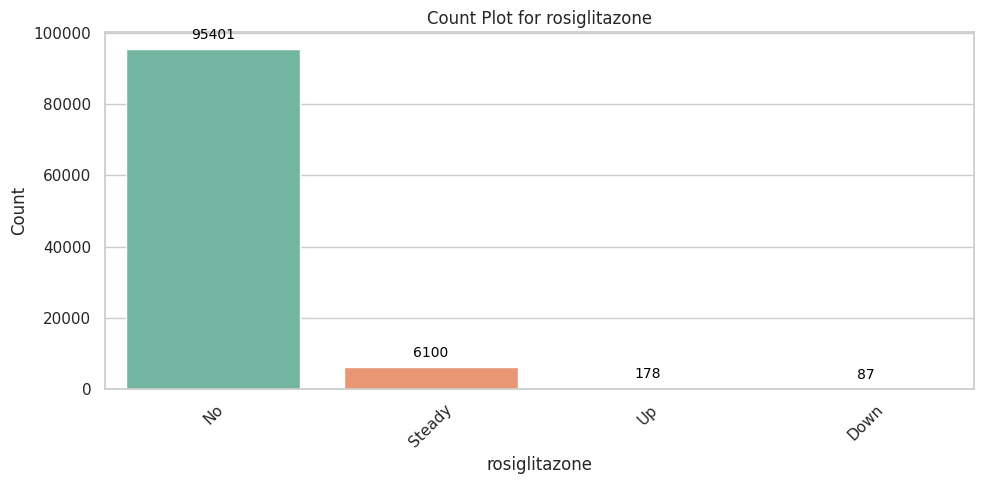

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


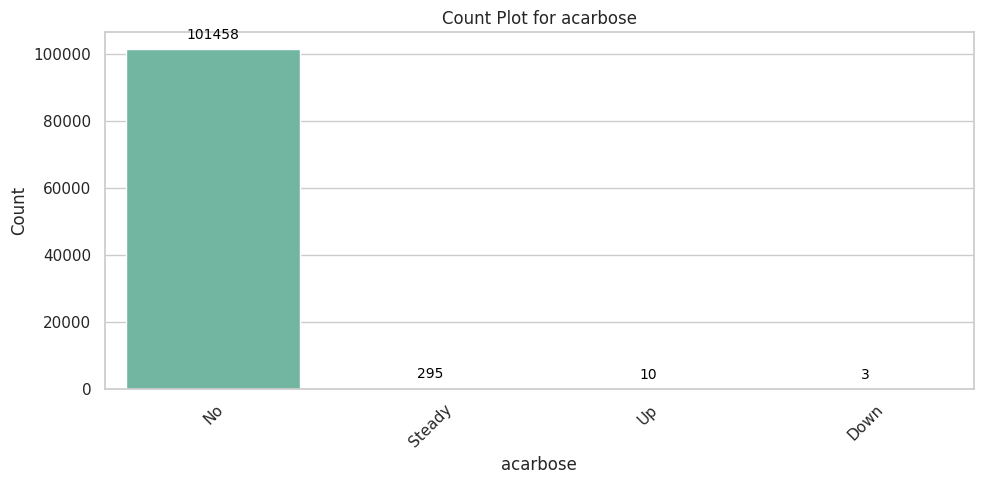

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


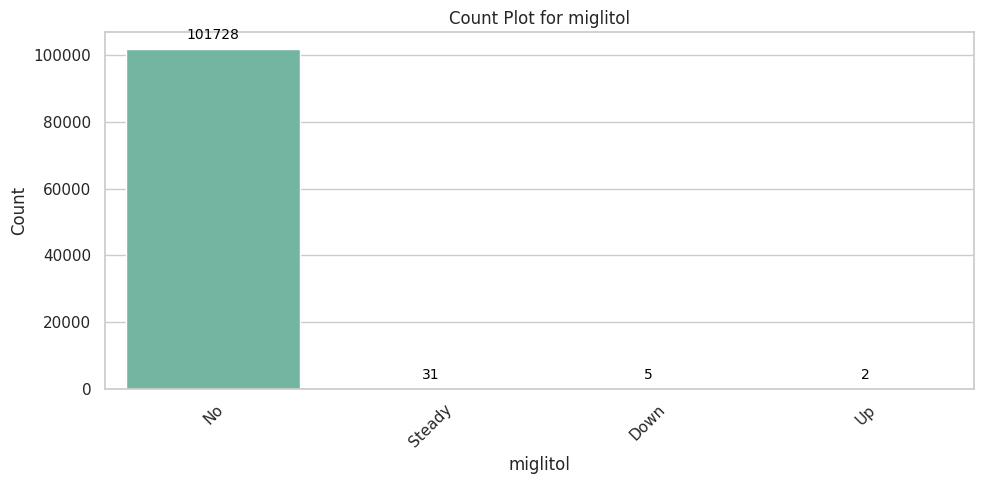

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


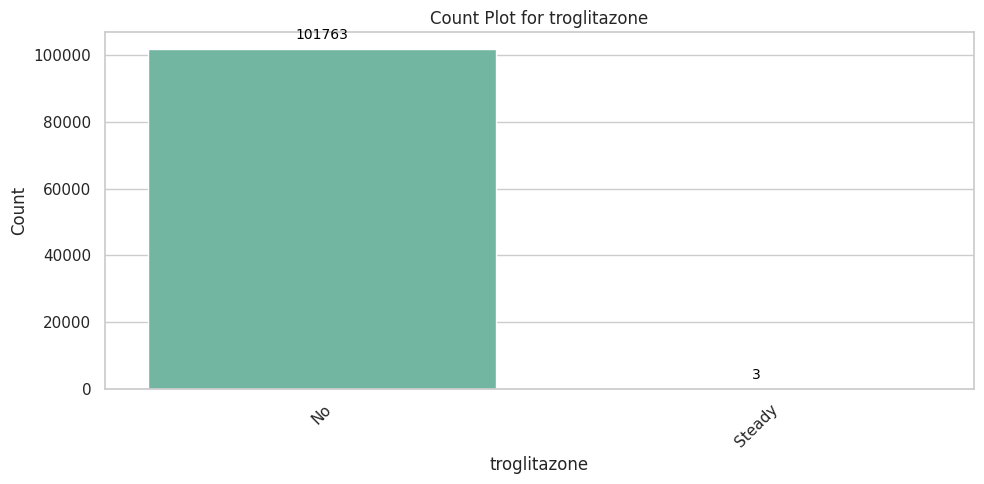

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


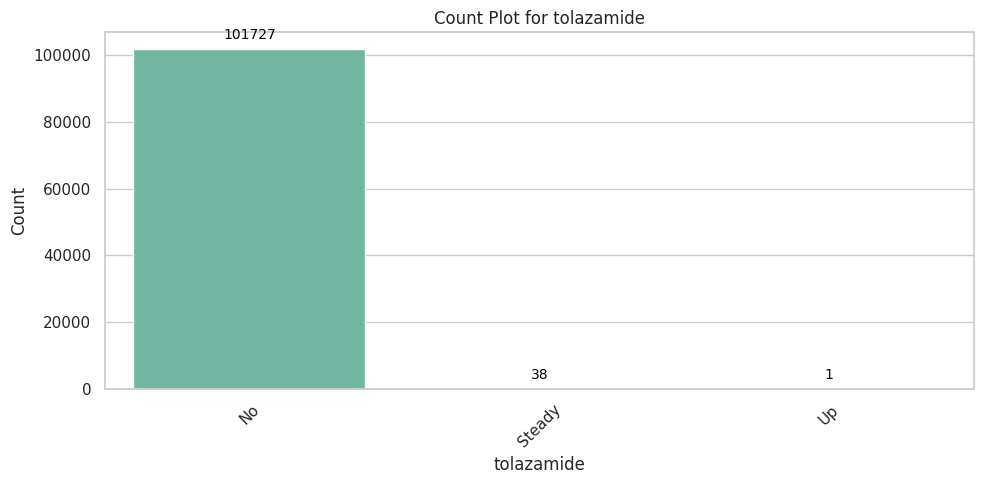

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


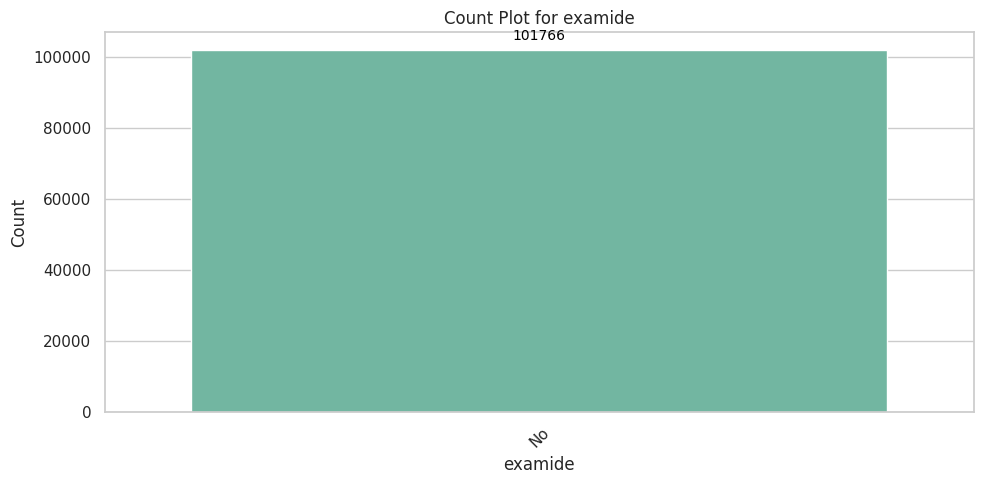

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


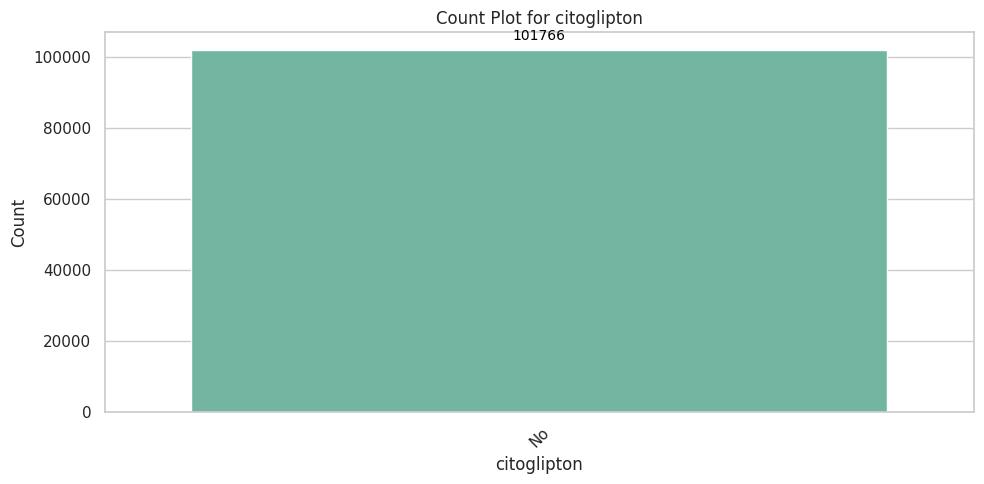

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


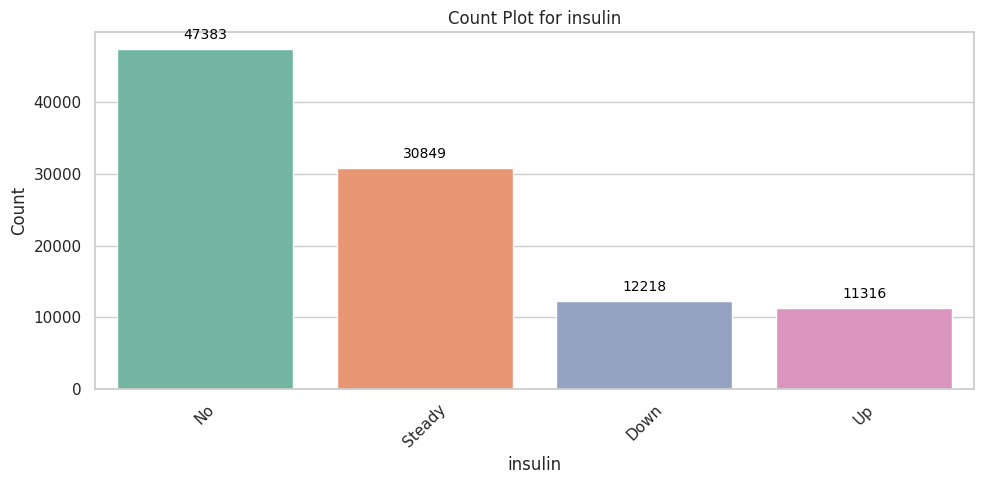

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


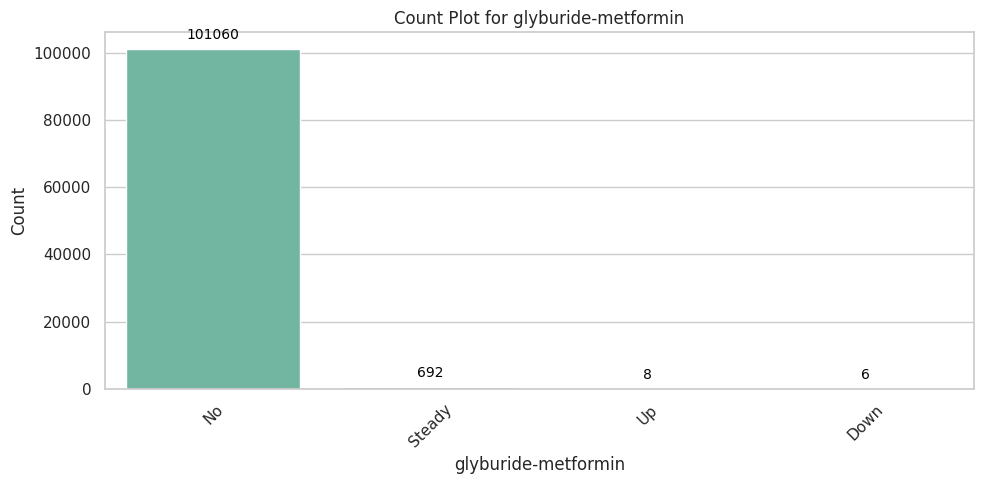

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


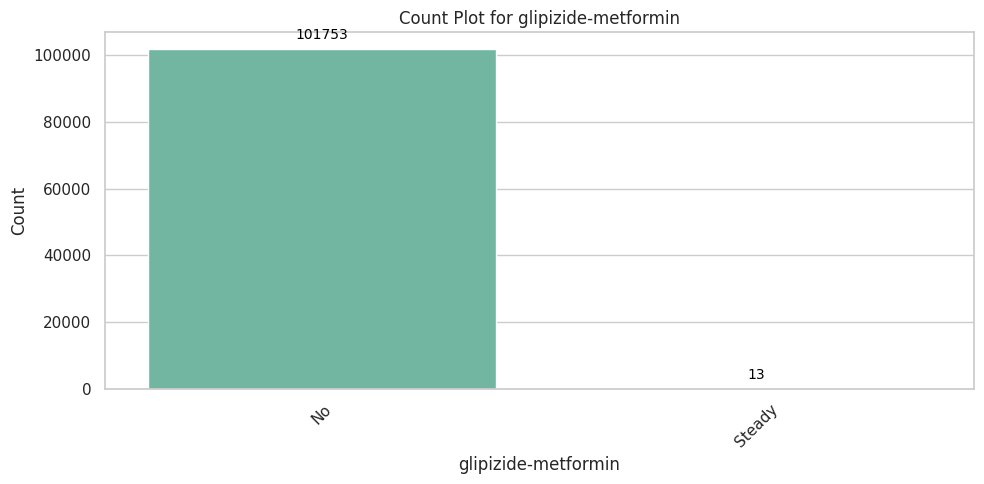

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


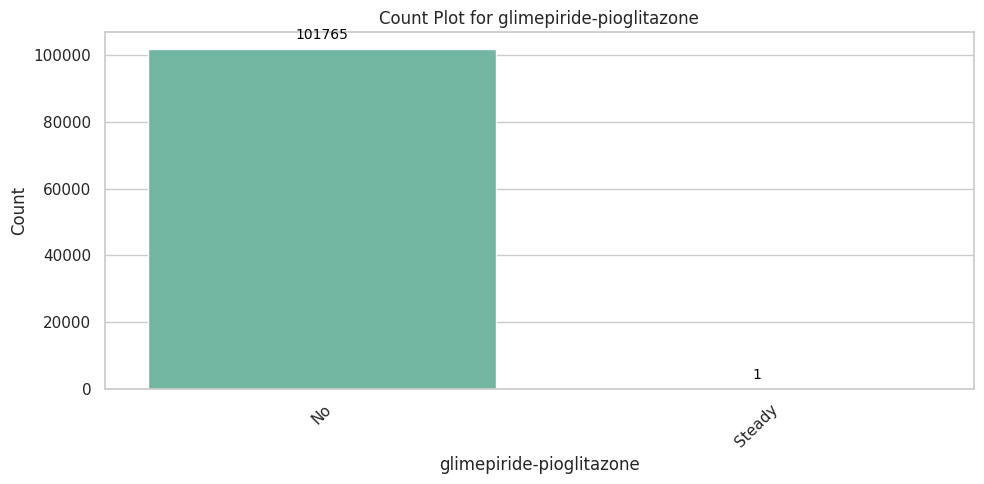

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


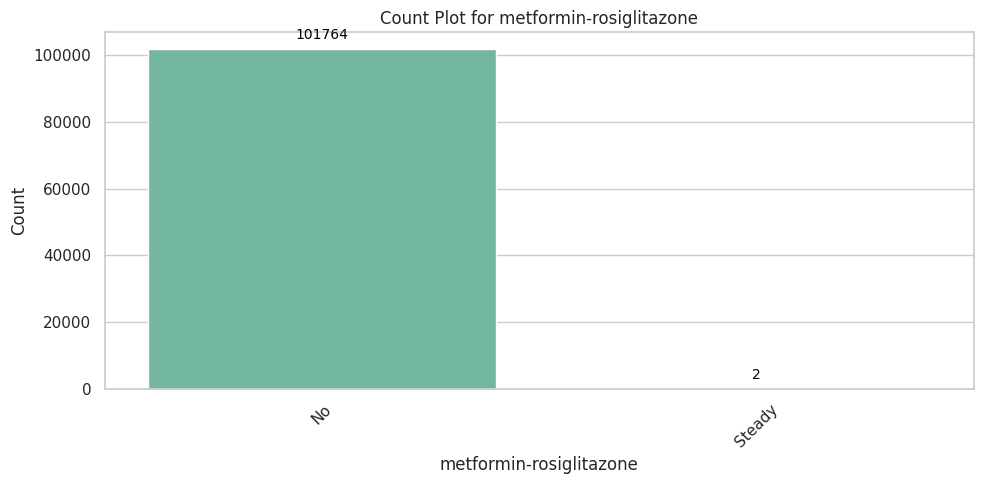

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


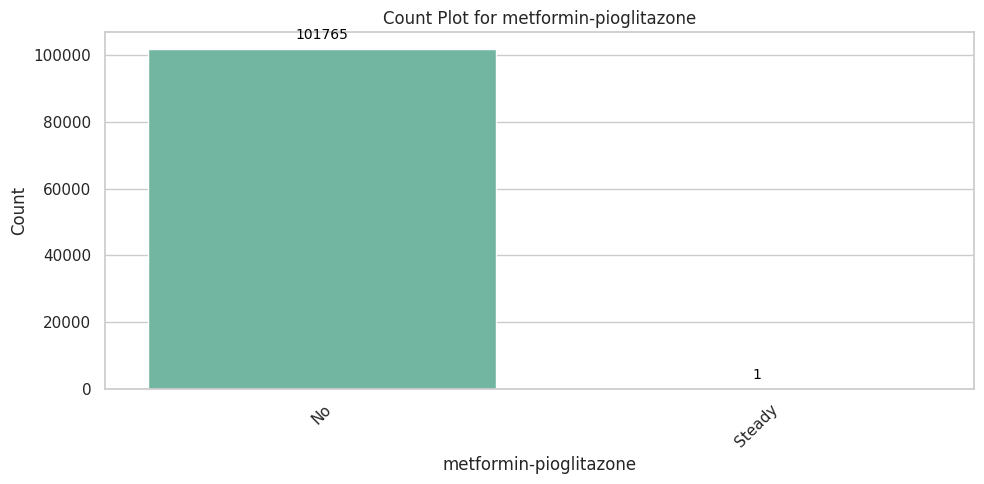

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


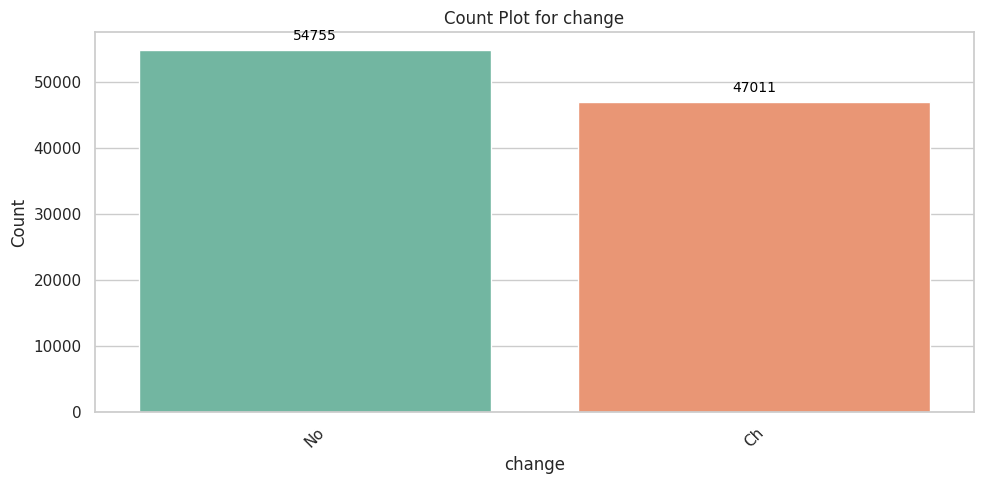

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


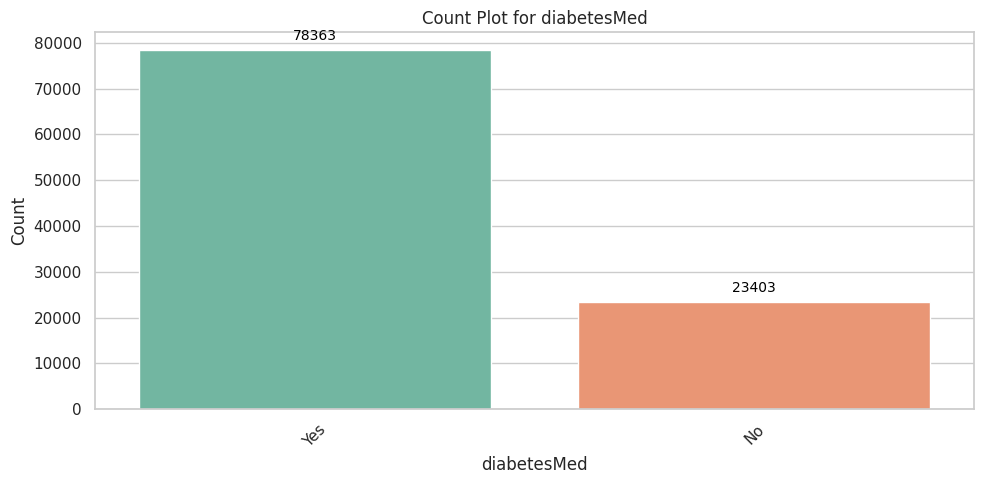

/tmp/ipython-input-1152391949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")


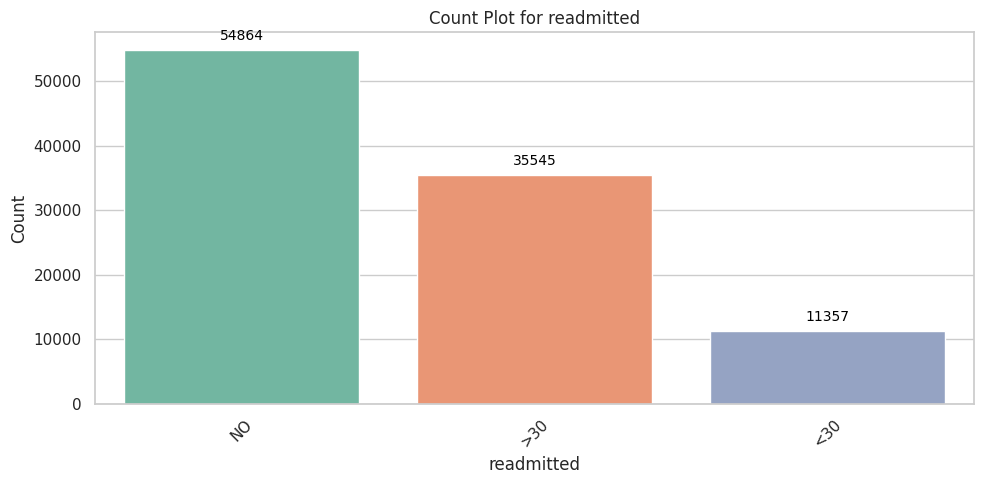

In [ ]:
cat_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() < 15]

for col in cat_cols:
    plt.figure(figsize=(10,5))
    ax = sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")

    # Add count labels on top of each bar
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    plt.title(f"Count Plot for {col}")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



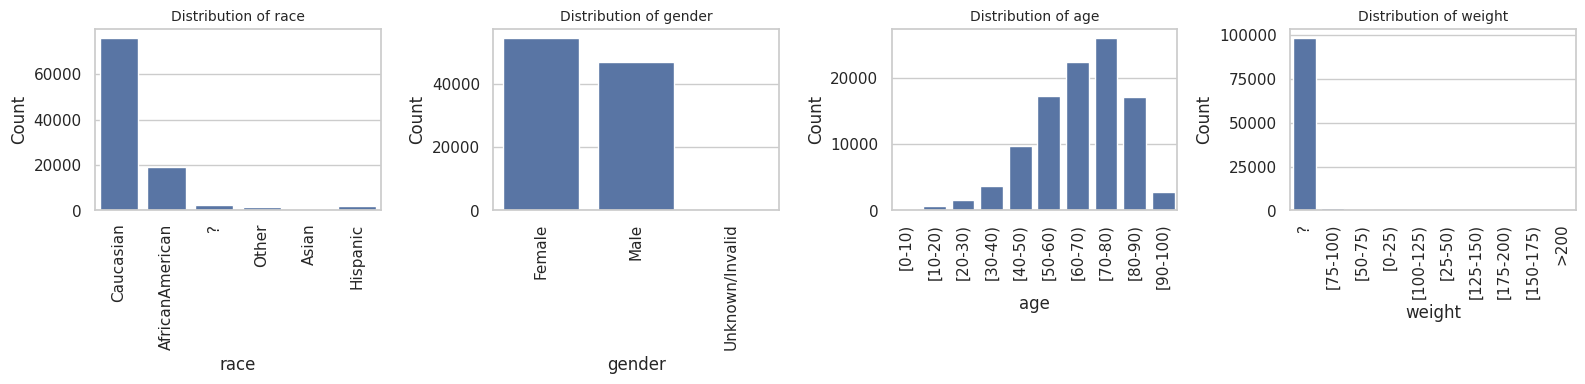

In [ ]:

# Define categorical demographics columns
demographics = ['race', 'gender', 'age', 'weight']

# Set grid size
n_cols = 5  # number of plots per row
n_rows = int(np.ceil(len(demographics) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Plot each categorical distribution
for i, col in enumerate(demographics):
    sns.countplot(x=df[col], color="C0", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


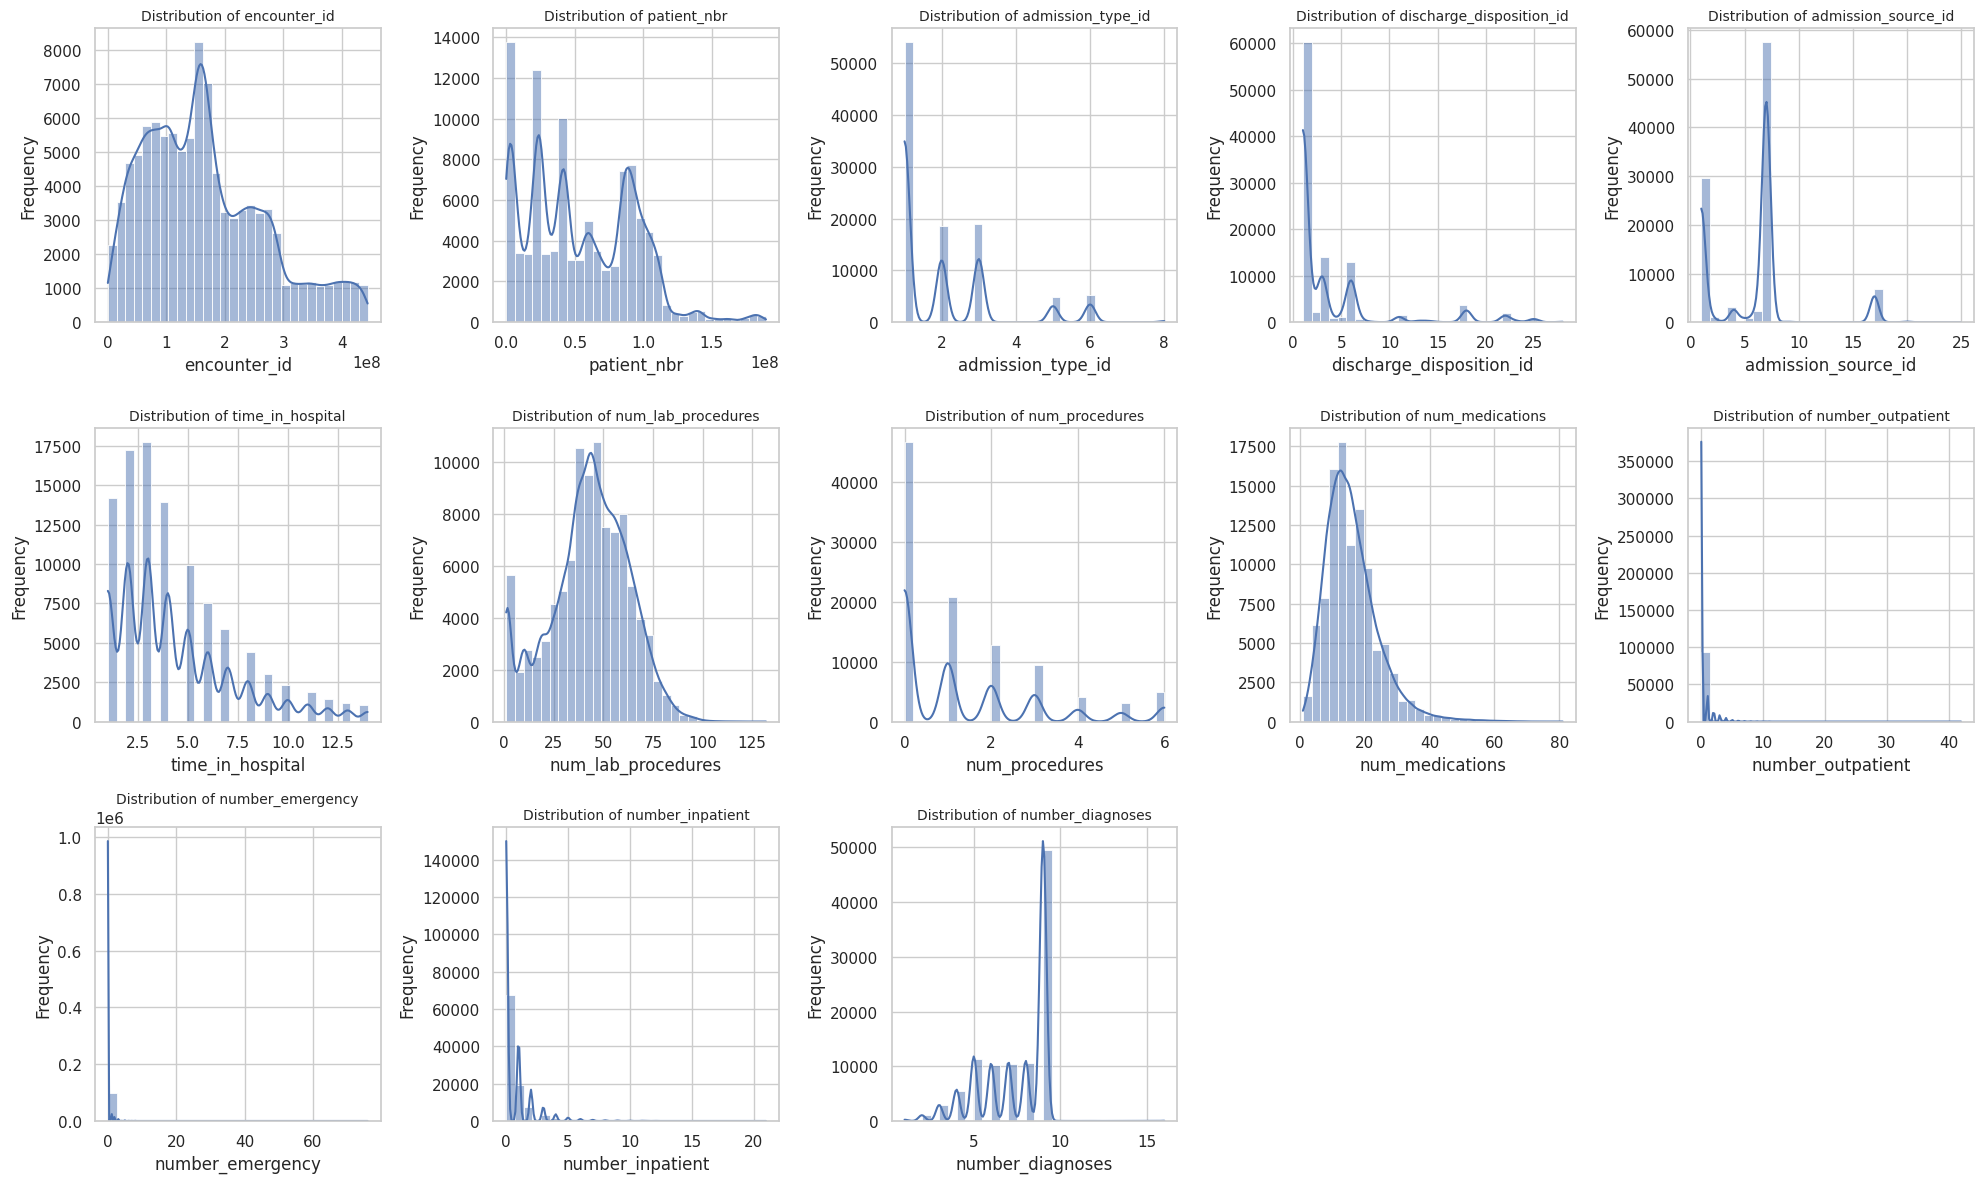

In [ ]:

# Select numeric columns
num_cols = df.select_dtypes(include=np.number).columns

# Set grid size
n_cols = 5  # number of plots per row
n_rows = int(np.ceil(len(num_cols) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

# Plot each distribution
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, color="C0", bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


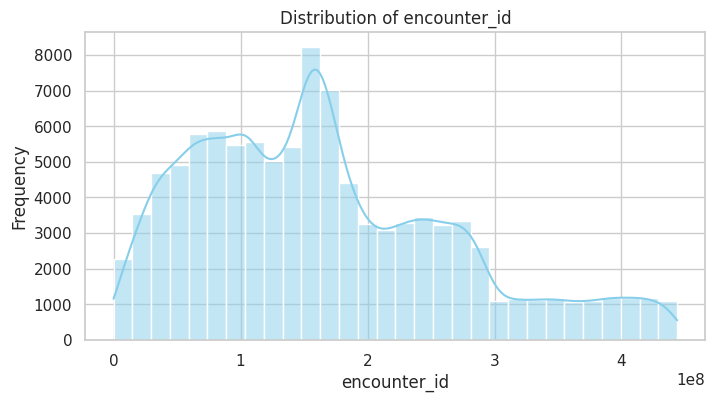

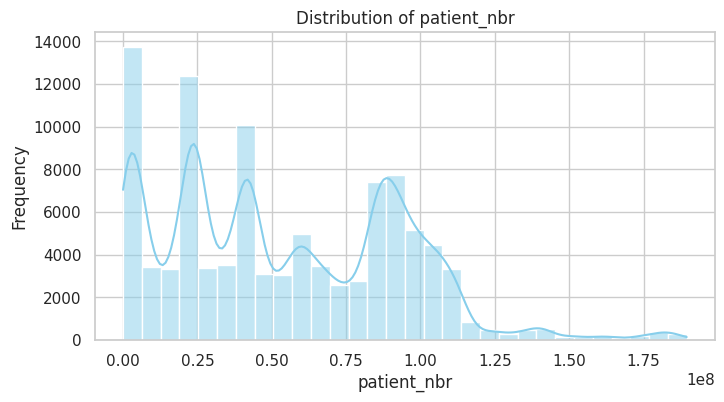

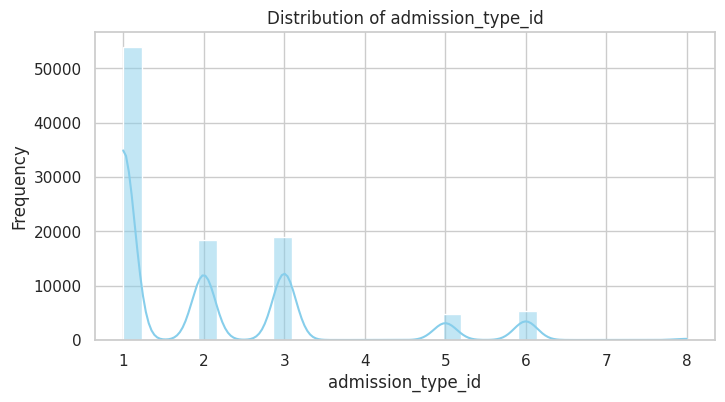

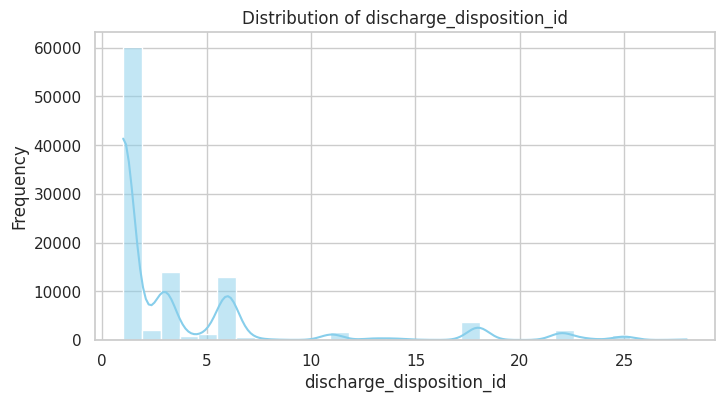

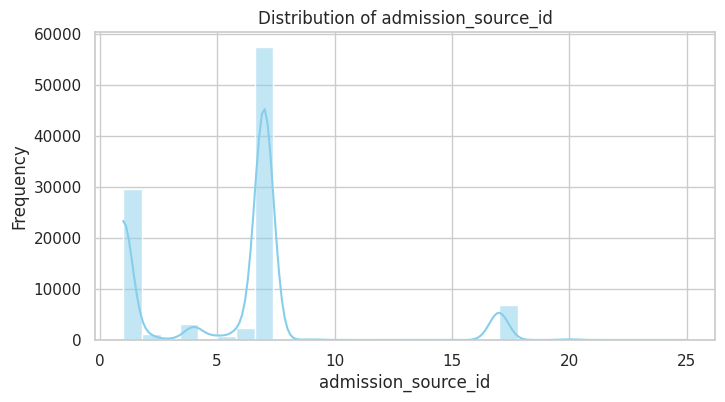

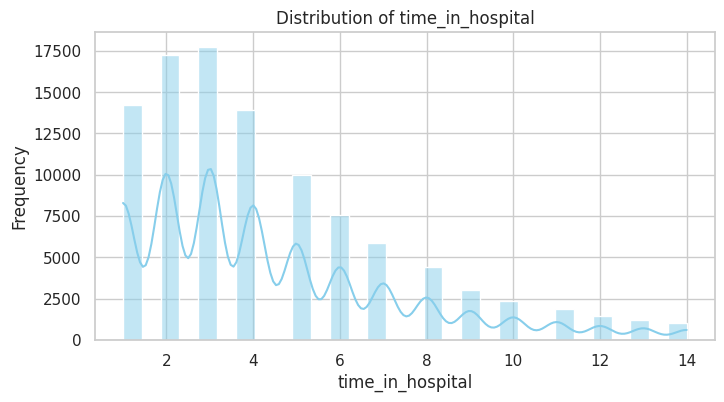

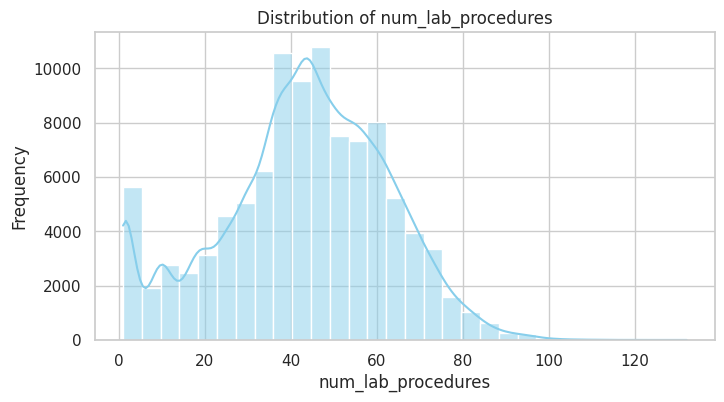

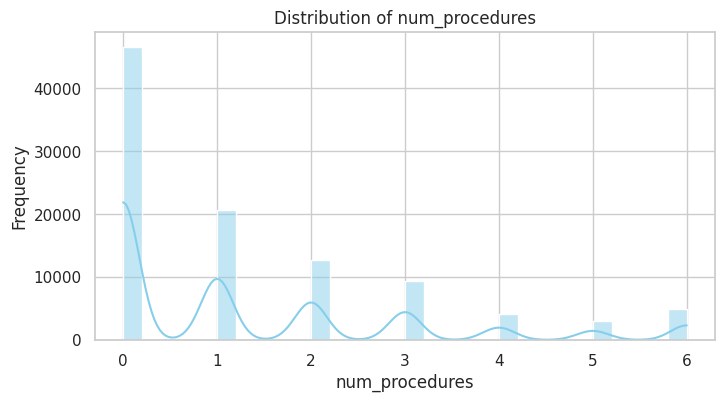

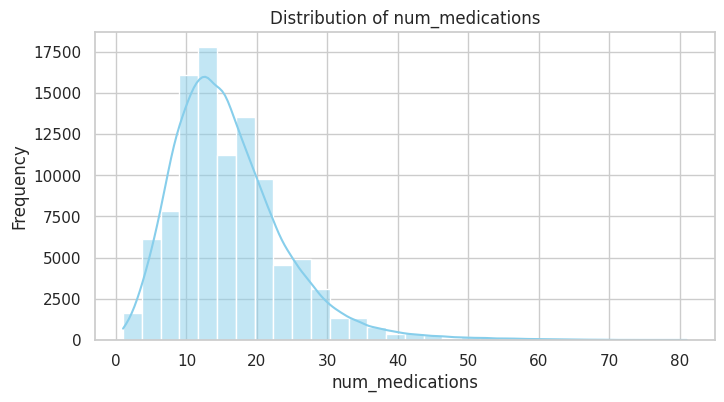

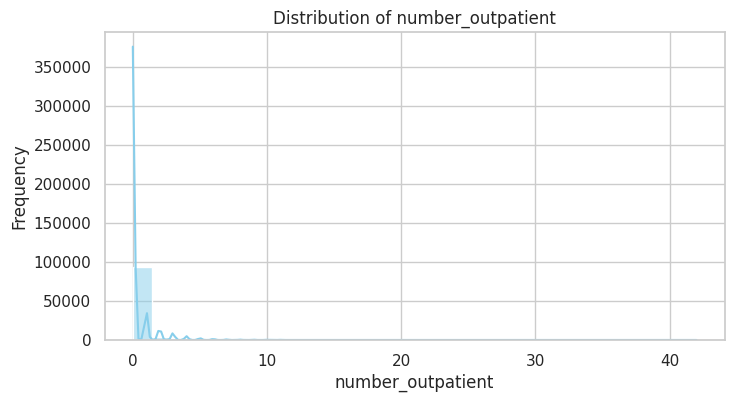

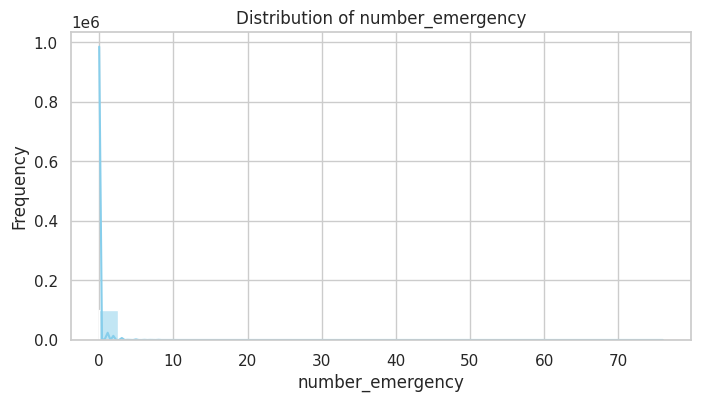

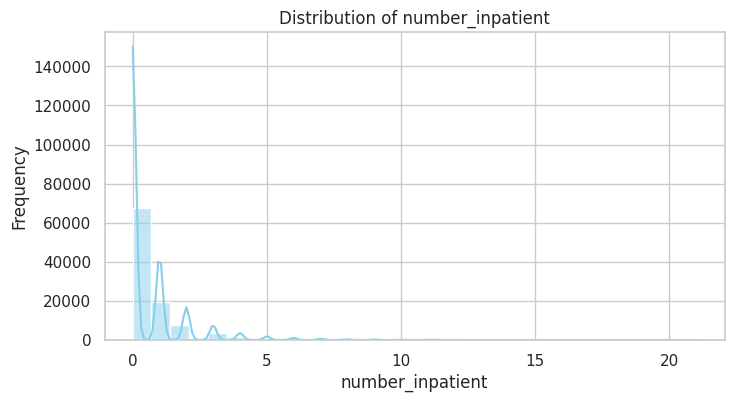

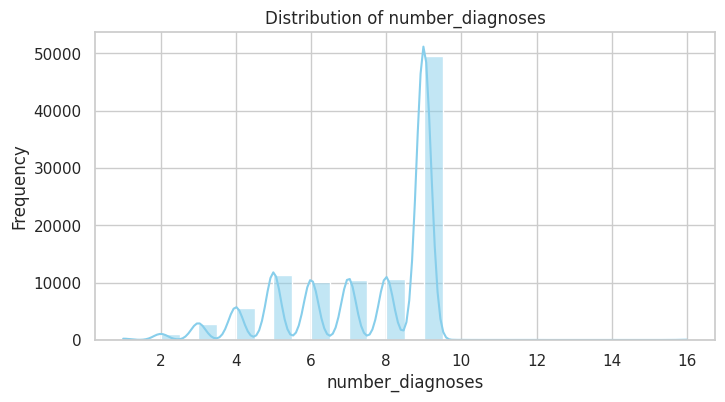

In [ ]:
# Plot distributions of numeric columns (limit to first 5 )
num_cols = df.select_dtypes(include=np.number).columns[:]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, color="skyblue", bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


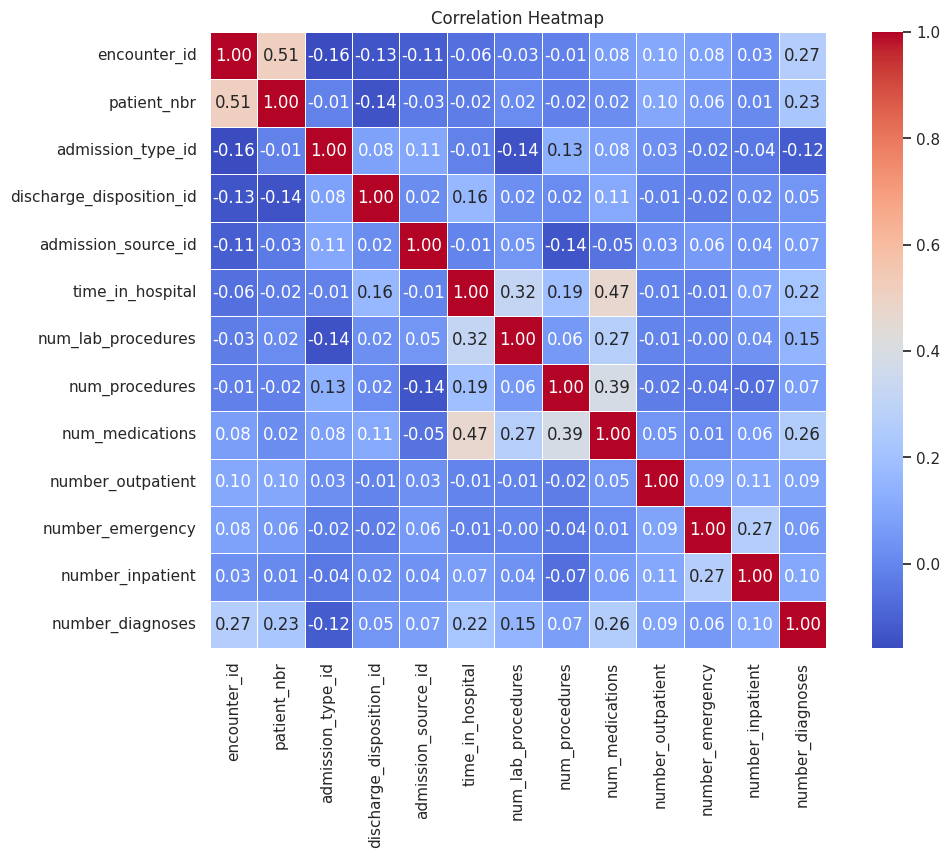

In [ ]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


## 3. Missing values

In [ ]:
# Count of missing values per column
missing_counts = df.isnull().sum()

In [ ]:
missing_counts

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
weight,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [ ]:
# Percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100

In [ ]:
missing_percent

,0
encounter_id,0.000000
patient_nbr,0.000000
race,0.000000
gender,0.000000
age,0.000000
weight,0.000000
admission_type_id,0.000000
discharge_disposition_id,0.000000
admission_source_id,0.000000
time_in_hospital,0.000000


In [ ]:
# Combine
missing_data = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage': missing_percent
})

In [ ]:

# Sort by percentage
missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
missing_data

,Missing Values,Percentage
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322


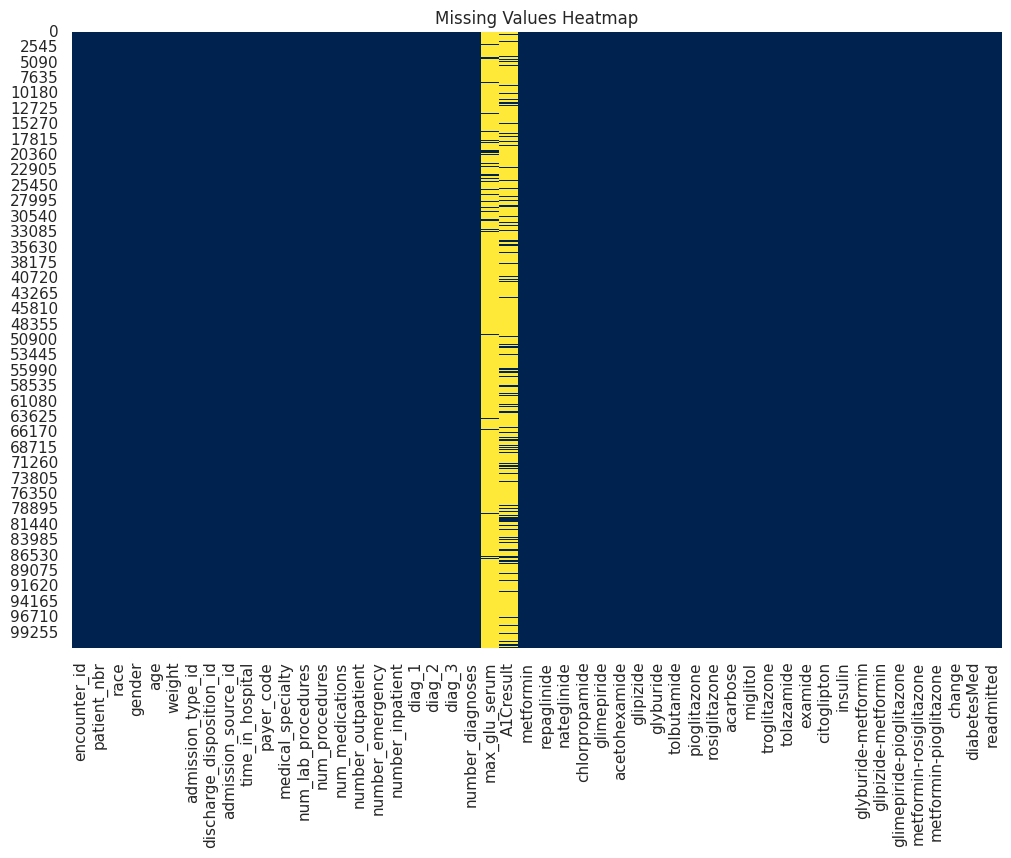

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap='cividis')
plt.title("Missing Values Heatmap")
plt.show()

/tmp/ipython-input-1467781059.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing.values, y=missing.index, palette="Set2")


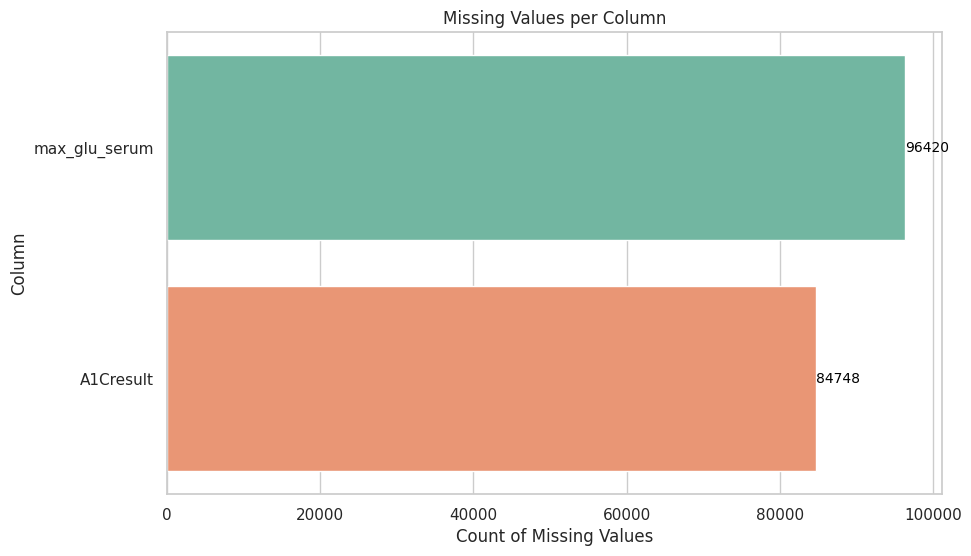

In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=missing.values, y=missing.index, palette="Set2")
plt.title("Missing Values per Column")
plt.xlabel("Count of Missing Values")
plt.ylabel("Column")

# Add value labels
for i, v in enumerate(missing.values):
    ax.text(v + 0.5, i, str(int(v)), color='black', va='center', fontsize=10)

plt.show()


## 4. Classification

In [ ]:
demographics = [
    'race',
    'gender',
    'age',
    'weight'
]


In [ ]:
hospitalization = [
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id',
    'time_in_hospital',
    'payer_code',
    'medical_specialty'
]


In [ ]:
medical_records = [
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'diag_1',
    'diag_2',
    'diag_3',
    'number_diagnoses',
    'max_glu_serum',
    'A1Cresult'
]


In [ ]:
medications = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]


In [ ]:
treatment_flags = [
    'change',
    'diabetesMed'
]


In [ ]:
target = [
    'readmitted'
]


## 5. Feature Importance

### XGBoost

In [ ]:
# Drop columns that contain non-useable administration data
encoded_df = df.drop(['encounter_id', 'patient_nbr', 'payer_code'], axis=1)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [ ]:
# Encode the categorical data
label_encoder = preprocessing.LabelEncoder()
categorical = encoded_df.select_dtypes(exclude =['number']).columns
columns = encoded_df[categorical].apply(label_encoder.fit_transform)
columns.head()

,race,gender,age,weight,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,0,0,1,38,124,650,670,3,3,...,0,1,1,0,0,0,0,1,0,2
1,3,0,1,1,0,143,79,121,3,3,...,0,3,1,0,0,0,0,0,1,1
2,1,0,2,1,0,454,78,767,3,3,...,0,1,1,0,0,0,0,1,1,2
3,3,1,3,1,0,554,97,248,3,3,...,0,3,1,0,0,0,0,0,1,2
4,3,1,4,1,0,54,24,86,3,3,...,0,2,1,0,0,0,0,0,1,2


In [ ]:
# Place the encoded data back into the dataset
encoded_df[list(columns.columns)] = columns
encoded_df = encoded_df.apply(pd.to_numeric, errors='coerce')
encoded_df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,0,0,1,6,25,1,1,38,41,...,0,1,1,0,0,0,0,1,0,2
1,3,0,1,1,1,1,7,3,0,59,...,0,3,1,0,0,0,0,0,1,1
2,1,0,2,1,1,1,7,2,0,11,...,0,1,1,0,0,0,0,1,1,2
3,3,1,3,1,1,1,7,2,0,44,...,0,3,1,0,0,0,0,0,1,2
4,3,1,4,1,1,1,7,1,0,51,...,0,2,1,0,0,0,0,0,1,2


In [ ]:
# Splitting data feature and labels:
X = encoded_df.drop('readmitted', axis=1) # X contains the features
y = encoded_df['readmitted'] # y is the target

In [ ]:
encoded_df.readmitted.unique()

array([2, 1, 0])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (81412, 46)
X_test shape: (20354, 46)
y_train shape: (81412,)
y_test shape: (20354,)


In [ ]:
# Train XGBoost model
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Evaluate the model's accuracy
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

XGBoost Accuracy: 0.5947725262847597


In [ ]:
# Calculate the Mean Squared Error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Mean Squared Error: {mse_xgb:.4f}")

XGBoost Mean Squared Error: 0.5939


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

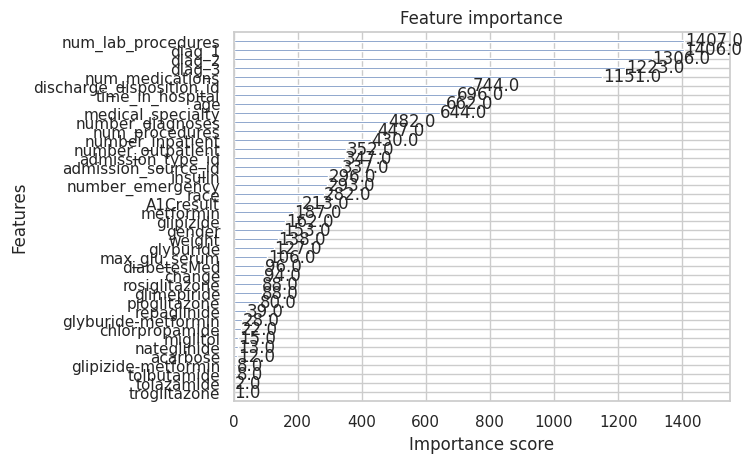

In [ ]:
# Plot feature importance
xgb.plot_importance(model_xgb)

In [ ]:
# Create labels for target values
labels = ['<30', '>30', 'No']
label_to_id = {label: i for i, label in enumerate(labels)}
label_to_id

{'<30': 0, '>30': 1, 'No': 2}

In [ ]:
# Get more performance metrics
report_xgb = classification_report(y_test, y_pred_xgb, target_names=labels)

print(f"XGB Classifier Accuracy: {accuracy_xgb}")
print("XGB Classifier Classification Report:\n", report_xgb)

XGB Classifier Accuracy: 0.5947725262847597
XGB Classifier Classification Report:
               precision    recall  f1-score   support

         <30       0.43      0.04      0.08      2285
         >30       0.51      0.42      0.46      7117
          No       0.63      0.82      0.71     10952

    accuracy                           0.59     20354
   macro avg       0.53      0.43      0.42     20354
weighted avg       0.57      0.59      0.55     20354

